## Installing the leap-ie library

In [ ]:
%pip install leap-ie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


## Generating a prototype

Ideally to begin understanding a model's understanding of classes, we would generate prototypes for all classes one-by-one and look for potential irregularities. The model we are using in this demo can be found on huggingface at the following URL: https://huggingface.co/skylord/swin-finetuned-food101 and has been extensively studied by our team.

We will showcase one interesting behaviour of the model involving the class 'Guacamole'.

In [ ]:
from leap_ie.vision import engine
from leap_ie.vision.models import get_model

prep, model, class_list = get_model(
    "skylord/swin-finetuned-food101", source="huggingface"
)

target_class = [51]  # Class ID for Guacamole

config = {"leap_api_key": "YOUR_API_KEY"}

res = engine.generate(
    project_name="food-101-case-study",
    model=model,
    class_list=class_list,
    config=config,
    target_classes=target_class,
    preprocessing=prep,
    samples=None,
    device=None,
    mode="pt",
)

Getting model food
Checking huggingface for skylord/swin-finetuned-food101


config.json:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/348M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Pytorch mode enabled.
Found device: cuda
Generating class prototypes...
Using device cuda


100%|██████████| 500/500 [00:52<00:00,  9.57it/s]


Waiting for logging to complete...
Finishing...


## Prototype for Guacamole
On the Leap Labs dashboard, you'll find a prototype that looks somewhat similar to this:

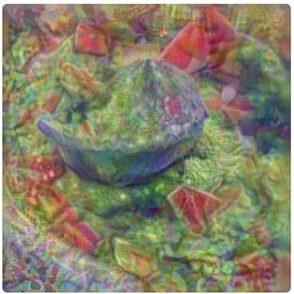

Ideally this prototype should look like a bowl of guacamole but the model has an expanded representation of the Guacamole class than that.

To predict Guacamole, we can see that the model looks for a bowl of guacamole on a bed of something resembling nacho chips.

The hypothesis that we come up with looking at the prototype is,

Guacamole = Bed of nacho chips + bowl + guacamole in bowl

Would the model still predict Guacamole if we retain two of these but replace another one?

## Image likely to be misclassified

Looking through google images, we find two images that contains a bowl of salsa on top of a bed of nacho chips.

Therefore our chosen images could be described as,

Chosen image = Bed of nacho chips + bowl + salsa in bowl

## Loading and preprocessing image

In [ ]:
!gdown 1GpHQ7va511V-qAlt1LHrd29b3srU2InK

Downloading...
From: https://drive.google.com/uc?id=1GpHQ7va511V-qAlt1LHrd29b3srU2InK
To: /content/nachos.zip
100% 742k/742k [00:00<00:00, 136MB/s]


In [ ]:
!unzip nachos.zip

Archive:  nachos.zip
   creating: nachos/
  inflating: __MACOSX/._nachos       
  inflating: nachos/nachos-with-salsa-2.jpg  
  inflating: __MACOSX/nachos/._nachos-with-salsa-2.jpg  
  inflating: nachos/nachos-with-salsa-1.jpg  
  inflating: __MACOSX/nachos/._nachos-with-salsa-1.jpg  


In [ ]:
import torch
import torchvision
import os

dir = '/content/nachos'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

paths = os.listdir(dir)
imgs = []
for path in paths:
    img = torchvision.io.read_image(dir + '/' + path).to(torch.float32)/255.0
    imgs.append(img.to(device))

for img in imgs:
    for p in prep:
        img = p(img)

for i in range(len(imgs)):
    with torch.no_grad():
        logits = model(imgs[i].unsqueeze(0))
        probs = torch.softmax(logits, dim=-1)
        print(f'{paths[i]} - Pred: {torch.argmax(logits)}, Nacho logit: {logits[0][66]}, Guacamole logit: {logits[0][51]}')


IMG_5549-scaled.jpg - Pred: 51, Nacho logit: 2.2879366874694824, Guacamole logit: 2.43019700050354
IMG_1501-scaled.jpg - Pred: 51, Nacho logit: 1.9397445917129517, Guacamole logit: 2.202033758163452


We see that the model predicts class 51 i.e. guacamole for these images containing salsa and not guacamole revealing a spurious correlation that might harm the model's performance in real-life use cases if deployed in situations where the above mentioned condition arises organically.